In [108]:
import pandas as pd
import spotipy
import spotipy.util as util
import numpy as np
import matplotlib.pyplot as plt

## Authentification

In [ ]:
USERNAME = 'SPOTIFY_USERNAME' #your spotify username
CLIENT_ID = 'ENTER_CLIENT_ID'#get from your developer Spotify account
CLIENT_SECRET = 'ENTER_SECRET_ID' #get from your developer Spotify account
REDIRECT_URI = 'http://localhost:8888/callback' #set at your developer account, usually "http://localhost:8000"
#SCOPE =  "user-top- read"
SCOPE = 'user-library-read'+","+ "user-read-recently-played"+","+ "user-top-read" + "," + 'playlist-modify-public' #

token = util.prompt_for_user_token(username = USERNAME, 
                                   scope = SCOPE, 
                                   client_id = CLIENT_ID, 
                                   client_secret = CLIENT_SECRET, 
                                   redirect_uri = REDIRECT_URI)

# get token
if token:
   sp = spotipy.Spotify(auth=token)

# test access
sp.current_user()


## Define Functions
### Function to receive musical features from given tracks:

In [93]:
# get features from List of tracks URIs 
def get_stuff_tracks(uri_tracks):
# get features
    features, features_base = [], []
    tracks, tracks_base = [], []
    j, n, step = 0, len(uri_tracks), 30

    while True: # make loop, becasue max # of elements is 50
        #print(j)
        if(j>n):
            break
        features_base = sp.audio_features(uri_tracks.loc[j : j+step, 'uri'])
        features.extend(features_base)
        tracks_base = sp.tracks(uri_tracks.loc[j : j+step, 'uri'])['tracks']
        tracks.extend(tracks_base)

        j += step + 1

    # put interesting stuff in dataframe
    df = pd.DataFrame() 
    for i, feature in enumerate(features):
        df.loc[i, 'artist_name'] = uri_tracks.loc[i, 'artist']
        df.loc[i, 'track_name'] = uri_tracks.loc[i, 'track']
        df.loc[i, 'uri'] = uri_tracks.loc[i, 'uri']
        list_genre.append(sp.artist(tracks[i]['artists'][0]['uri'])['genres'])
        #print("list genre")
        df.loc[i, 'valence'] = feature['valence']
        df.loc[i, 'danceability'] = feature['danceability']
        df.loc[i, 'energy'] = feature['energy']
        df.loc[i, 'speechiness'] = feature['speechiness'] # if >0.66 most probably entirely spoken
        df.loc[i, 'acousticness'] = feature['acousticness']
        df.loc[i, 'liveness'] = feature['liveness']
        df.loc[i, 'tempo'] = feature['tempo']
        df.loc[i, 'mode'] = feature['mode']
        df.loc[i, 'key'] = feature['key']
        df.loc[i, 'time_signature'] = feature['time_signature']
        df.loc[i, 'duration'] = feature['duration_ms']
        df.loc[i, 'analysis_url'] = feature['analysis_url']
        df.loc[i, 'popularity'] = tracks[i]['popularity']
    #        df.loc[i, 'release'] = sp.album(tracks[i]['track']['album']['uri'])['release_date'] # Carefull, slow!
        df.loc[i, 'album_uri'] = tracks[i]['album']['uri']
        df.loc[i, 'album_name'] = tracks[i]['album']['name']
        df.loc[i, 'track_uri'] = tracks[i]['uri']
        
        #print(i)
    return(df)




### Function to receive the Top100 tracks and features from the logged-in user:

In [94]:
def get_stuff_user(timerange = "medium_range"):
    
    ## get tracks
    # its seems only to be possible to catch 99 tracks in total (49 + 50)
    results = sp.current_user_top_tracks(limit = 49, offset = 0, time_range=timerange) # only 50 per request
    tracks = results['items']
    results = sp.current_user_top_tracks(limit = 50, offset = 49, time_range=timerange) # only 50 per request
    tracks = tracks + results['items']
    
    for item in tracks:
        track = item
        print(track['name'] + ' - ' + track['artists'][0]['name'])
    tids = []
    for i, t in enumerate(tracks):
        #print(' ', i, t['name'])
        tids.append(t['uri'])
    
    # get features
    features, features_base = [], []
    j, n, step = 0, len(tracks), 30
    while True: # make loop, becasue max # of elements is 50
        features_base = sp.audio_features(tids[j : j+step])
        features.extend(features_base)
        if(j>n):
            break
        else:
            j += step
    del features[-1] # remove last entry which es empty
    
    # put interesting stuff in dataframe
    df = pd.DataFrame() 
    for i, feature in enumerate(features):
        df.loc[i, 'artist_name'] = tracks[i]['artists'][0]['name']
        df.loc[i, 'album_name'] = tracks[i]['album']['name']
        df.loc[i, 'track_name'] = tracks[i]['name']
        df.loc[i, 'popularity'] = tracks[i]['popularity']
#        df.loc[i, 'release'] = sp.album(tracks[i]['track']['album']['uri'])['release_date'] # Carefull, slow!
        df.loc[i, 'album_uri'] = tracks[i]['album']['uri']
        df.loc[i, 'track_uri'] = tracks[i]['uri']
        df.loc[i, 'valence'] = feature['valence']
        df.loc[i, 'danceability'] = feature['danceability']
        df.loc[i, 'energy'] = feature['energy']
        df.loc[i, 'speechiness'] = feature['speechiness'] # if >0.66 most probably entirely spoken
        df.loc[i, 'acousticness'] = feature['acousticness']
        df.loc[i, 'liveness'] = feature['liveness']
        df.loc[i, 'tempo'] = feature['tempo']
        df.loc[i, 'mode'] = feature['mode']
        df.loc[i, 'key'] = feature['key']
        df.loc[i, 'time_signature'] = feature['time_signature']
        df.loc[i, 'duration'] = feature['duration_ms']
        df.loc[i, 'analysis_url'] = feature['analysis_url']
        #print(i)
    return(df)

## Analyze Top100 Songs of all Generations

### Import Spotify-Data (Top100 Songs) for all Generations

In [104]:
uris_x = pd.read_csv("Data_Input/gen_x.csv", encoding="utf-8",  sep=';',)
uris_y = pd.read_csv("Data_Input/gen_y.csv", encoding="utf-8",  sep=';',)
uris_z = pd.read_csv("Data_Input/gen_z.csv", encoding="utf-8",  sep=';',)
uris_boomer = pd.read_csv("Data_Input/gen_boomer.csv", encoding="utf-8",  sep=';',)


Example for Generation X:

In [105]:
uris_x.head()

,uri,artist,track
0,spotify:track:3dfCKQy9JY2ixI58zTeUn9,Lo & Leduc,079
1,spotify:track:0E9ZjEAyAwOXZ7wJC0PD33,Dynoro,In My Mind
2,spotify:track:2VxeLyX666F8uXCJ0dZF8B,Lady Gaga,Shallow
3,spotify:track:63SevszngYpZOwf63o61K4,Dennis Lloyd,Nevermind
4,spotify:track:7ef4DlsgrMEH11cDZd32M6,Calvin Harris,One Kiss (with Dua Lipa)


### Get Musical Features for all Songs

In [106]:
# This step takes up to 1 Minute

list_genre = []
df_boomer = get_stuff_tracks(uris_boomer)
list_genre_boomer = list_genre
flat_list_boomer = pd.Series([item for sublist in list_genre_boomer for item in sublist])
a_boomer = flat_list_boomer.value_counts()

list_genre = []
df_x = get_stuff_tracks(uris_x)
list_genre_x = list_genre
flat_list_x = pd.Series([item for sublist in list_genre_x for item in sublist])
a_x = flat_list_x.value_counts()

list_genre = []
df_y = get_stuff_tracks(uris_y)
list_genre_y = list_genre
flat_list_y = pd.Series([item for sublist in list_genre_y for item in sublist])
a_y = flat_list_y.value_counts()

list_genre = []
df_z = get_stuff_tracks(uris_z)
list_genre_z = list_genre
flat_list_z = pd.Series([item for sublist in list_genre_z for item in sublist])
a_z= flat_list_z.value_counts()


### Analyse Musical Features

In [95]:
# meta analysis --> All the mean values per generation in one dataframe
data_gen = {'gen_boomer':df_boomer, 'gen_x':df_x, 'gen_y':df_y, 'gen_z':df_z}

df_meta = pd.DataFrame()
generations = ['gen_boomer', 'gen_x', 'gen_y', 'gen_z']

for generation in generations:
    #print(generation)
    df_meta.loc[generation, 'speechiness'] = data_gen[generation]['speechiness'].mean()
    df_meta.loc[generation, 'danceability'] = data_gen[generation]['danceability'].mean()
    df_meta.loc[generation, 'energy'] = data_gen[generation]['energy'].mean()

    df_meta.loc[generation, 'valence'] = data_gen[generation]['valence'].mean()
    df_meta.loc[generation, 'acousticness'] = data_gen[generation]['acousticness'].mean()
    df_meta.loc[generation, 'liveness'] = data_gen[generation]['liveness'].mean()
    
    df_meta.loc[generation, 'popularity'] = data_gen[generation]['popularity'].mean()
    df_meta.loc[generation, 'tempo'] = data_gen[generation]['tempo'].mean()
    df_meta.loc[generation, 'duration'] = data_gen[generation]['duration'].mean()

# store average featrue values
df_meta.to_csv("Data_Output/all_gen_average_values.csv")

**Average feature values of all generations:**

In [107]:
df_meta

,speechiness,danceability,energy,valence,acousticness,liveness,popularity,tempo,duration
gen_boomer,0.068757,0.63980,0.61494,0.525176,0.268999,0.189081,71.56,113.57911,228427.69
gen_x,0.086259,0.67036,0.64807,0.485440,0.220222,0.170916,72.43,114.08357,216141.54
gen_y,0.105976,0.70611,0.67971,0.488773,0.194504,0.159619,74.26,113.74485,207594.26
gen_z,0.140021,0.72118,0.64611,0.481063,0.233753,0.152749,72.89,114.77119,199376.87


**Plot average values for all generations:**

Text(0.5, 0.97, 'Musical Taste of Swiss Spotify Listeners by Generation')

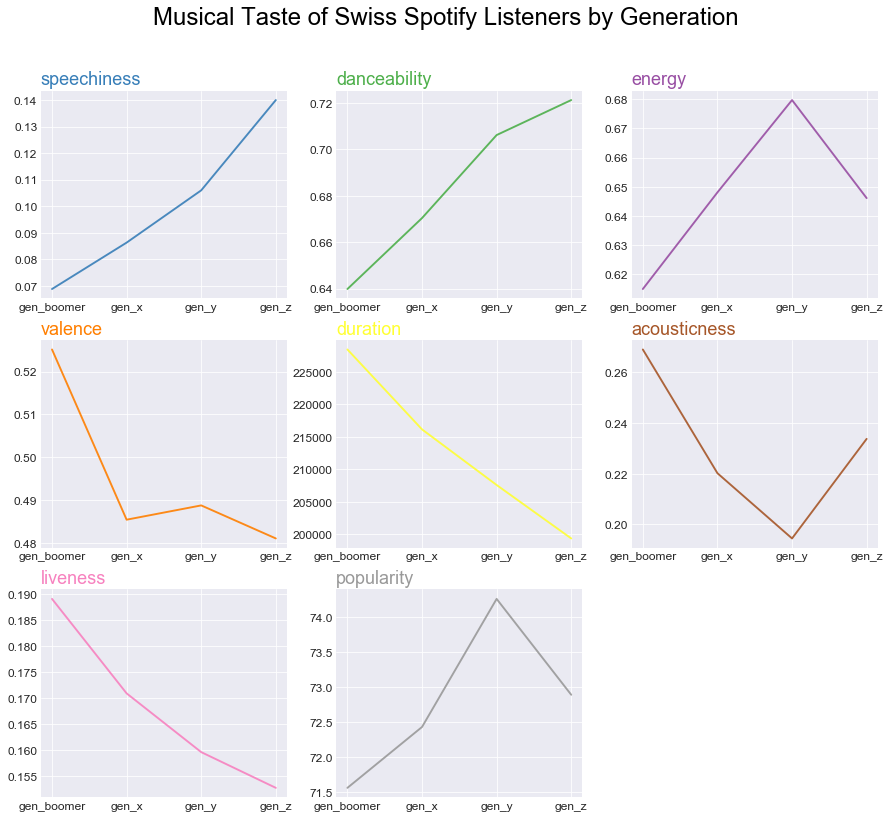

In [90]:

features_top = ['speechiness', 'danceability', 'energy', 'valence', 'duration', 'acousticness', 'liveness', 'popularity']

# Initialize the figure
plt.style.use('seaborn-darkgrid')
# create a color palette
palette = plt.get_cmap('Set1')
# multiple line plot
num=0
plt.rcParams['figure.figsize'] = [15, 13]
plt.rcParams.update({'font.size': 12})

for feature in features_top:
    num+=1
    # Find the right spot on the plot
    plt.subplot(3,3, num)
    #print(feature)
    plt.plot(generations, df_meta[feature][0:4], marker='', color=palette(num), linewidth=1.9, alpha=0.9, label=feature)

    # Add title
    plt.title(feature, loc='left', fontsize=18, fontweight=0, color=palette(num) )
#a = list(["a", "b", "c", "d"])
# general title
plt.suptitle("Musical Taste of Swiss Spotify Listeners by Generation",  fontsize=24, fontweight=0, color='black', y=0.97)
# Axis title
#plt.text(1, -0.04, 'Generation', ha='center', va='center', transform=ax.transAxes, fontsize=18)
#plt.text(0.02, 0.5, 'Note', ha='center', va='center', rotation='vertical')





### Which Artists appear most Often in the Top100 Tracks?

In [101]:
df_top_gen_boomer = pd.DataFrame()
df_top_gen_x = pd.DataFrame()
df_top_gen_y = pd.DataFrame()
df_top_gen_z = pd.DataFrame()
df_top_gen_boomer.loc[:, 'count'] = df_boomer.artist_name.value_counts()
df_top_gen_x.loc[:, 'count'] = df_x.artist_name.value_counts()
df_top_gen_y.loc[:, 'count'] = df_y.artist_name.value_counts()
df_top_gen_z.loc[:, 'count'] = df_z.artist_name.value_counts()

df_top = df_top_gen_boomer.merge(df_top_gen_x, left_index = True, right_index = True, how = 'outer', suffixes = ('boomer', 'x')).merge(df_top_gen_y, left_index = True, right_index = True, how = 'outer', suffixes = ('', 'y')).merge(df_top_gen_z, left_index = True, right_index = True, how = 'outer', suffixes = ('y', 'z'))
df_top.loc[:, 'total'] = df_top.apply(np.nansum, axis = 1)

# store artist count
df_top.to_csv("Data_Output/all_gen_artists_count.csv")



In [102]:
df_top = df_top.sort_values("total", ascending = False)
df_top.head()


,countboomer,countx,county,countz,total
Ed Sheeran,6.0,6.0,2.0,NaN,14.0
Capital Bra,NaN,1.0,3.0,8.0,12.0
Drake,2.0,2.0,4.0,4.0,12.0
Imagine Dragons,1.0,5.0,3.0,2.0,11.0
XXXTENTACION,1.0,2.0,3.0,5.0,11.0


## User Top100 Tracks

### Get the Users Top100 Tracks

In [77]:
## get stuff user ####
df_user = get_stuff_user(timerange = "medium_term") # Medium term takes into account the last 6 Month

# remove Hörbücher
df_user = df_user[df_user['speechiness'] < 0.66] # Tracks with >0.66 are most probably spoken texts (audiobooks)

Reindeer King - Tori Amos
Waste - Evelinn Trouble
De Flamingo - Cabaret Rotstift
Hunger - Florence + The Machine
Sky Full Of Song - Florence + The Machine
Nail - Zola Jesus
Big God - Florence + The Machine
Go With The Flow - Queens of the Stone Age
Never Came Around - Evelinn Trouble
Monstruous - Evelinn Trouble
Traffic - Thom Yorke
Saltlick - Homeless Remix - Len Sander
Back Where I Belong - Baroness
Cherry Lady - Capital Bra
You're Not Scared of Losing Me - Evelinn Trouble
Rise and Fall - Sophie Hunger
Die Ganze Welt - Sophie Hunger
Hope Music - Evelinn Trouble
You've Got The Love - Florence + The Machine
De Tiger - Cabaret Rotstift
Moderation - Florence + The Machine
Not Important - Evelinn Trouble
Bliss - Muse
Sonnenbrille - Loredana
Wir ticken - Capital Bra
Morningstar - Baroness
Die Leiche - Farin Urlaub Racing Team
Lass mich nicht los - Faber
Green Machine - Kyuss
No Class - Evelinn Trouble
Hallelujah - Jeff Buckley
100 Degrees - Kyuss
Dog Days Are Over - Florence + The Machine


### Get the average feature values of the users Top100 Tracks

In [85]:
df_meta_user = pd.DataFrame()

df_meta_user.loc['user', 'speechiness'] = df_user['speechiness'].mean()
df_meta_user.loc['user', 'danceability'] = df_user['danceability'].mean()
df_meta_user.loc['user', 'energy'] = df_user['energy'].mean()

df_meta_user.loc['user', 'valence'] = df_user['valence'].mean()
df_meta_user.loc['user', 'acousticness'] = df_user['acousticness'].mean()
df_meta_user.loc['user', 'liveness'] = df_user['liveness'].mean()

df_meta_user.loc['user', 'popularity'] = df_user['popularity'].mean()
df_meta_user.loc['user', 'tempo'] = df_user['tempo'].mean()
df_meta_user.loc['user', 'duration'] = df_user['duration'].mean()


**Average feature-values:**

In [86]:
df_meta_user

,speechiness,danceability,energy,valence,acousticness,liveness,popularity,tempo,duration
user,0.076062,0.493414,0.54233,0.331775,0.378147,0.17774,39.646465,122.637,266683.444444
